In [704]:
path = "../results/sst-5/llama/CAPO/hyper_shuffle/benchmark_experiment_sst-5_llama_CAPO_44/4846db6a3aff5876b5cd8e35437b18249c9e97a2bc24b03474652465c7b7f2d1/step_results_eval.csv"

In [705]:
import matplotlib.pyplot as plt
import pandas as pd

In [706]:
df = pd.read_csv(path)
df

,step,timestamp,time_elapsed,score,prompt,input_tokens_meta_llm,output_tokens_meta_llm,input_tokens_downstream_llm,output_tokens_downstream_llm,test_score
0,1,2025-03-15 00:34:31.318891,203.501687,0.563333,How would you describe the sentiment of this m...,1437,453,369773,60868,0.600
1,1,2025-03-15 00:34:31.318891,203.501687,0.547390,"Given this movie critique, determine whether t...",1437,453,369773,60868,0.558
2,1,2025-03-15 00:34:31.318891,203.501687,0.541135,What sentiment does this movie review convey? ...,1437,453,369773,60868,0.594
3,1,2025-03-15 00:34:31.318891,203.501687,0.531124,Examine the movie review and determine its sen...,1437,453,369773,60868,0.586
4,1,2025-03-15 00:34:31.318891,203.501687,0.529277,Evaluate the emotional content of the followin...,1437,453,369773,60868,0.570
...,...,...,...,...,...,...,...,...,...,...
435,44,2025-03-15 01:44:54.511917,176.977803,0.509538,Analyze the emotional tone of the given movie ...,3343,1975,517024,59195,0.602
436,44,2025-03-15 01:44:54.511917,176.977803,0.507661,Movie sentiment classification task: Examine t...,3343,1975,517024,59195,0.570
437,44,2025-03-15 01:44:54.511917,176.977803,0.488233,Movie sentiment analysis task: Evaluate the em...,3343,1975,517024,59195,0.568
438,44,2025-03-15 01:44:54.511917,176.977803,0.484759,Movie sentiment classification task: Examine t...,3343,1975,517024,59195,0.528


In [707]:
df["total_tokens"] = (
    df["output_tokens_meta_llm"]
    + df["input_tokens_meta_llm"]
    + df["output_tokens_downstream_llm"]
    + df["input_tokens_downstream_llm"]
)
df["total_tokens"] = df["total_tokens"].cumsum()

In [708]:
# cum of tokens
df["output_tokens_downstream_llm_cum"] = df["output_tokens_downstream_llm"].cumsum()
df["output_tokens_meta_llm_cum"] = df["output_tokens_meta_llm"].cumsum()
df["input_tokens_downstream_llm_cum"] = df["input_tokens_downstream_llm"].cumsum()
df["input_tokens_meta_llm_cum"] = df["input_tokens_meta_llm"].cumsum()

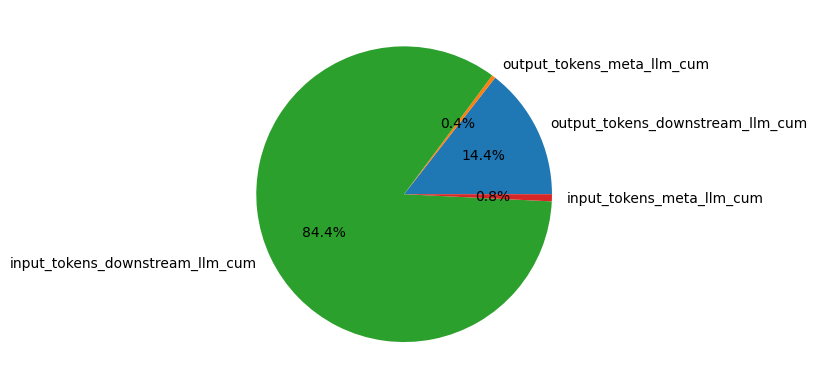

In [709]:
# plot pie
fig, ax = plt.subplots()
ax.pie(
    [
        df["output_tokens_downstream_llm_cum"].iloc[-1],
        df["output_tokens_meta_llm_cum"].iloc[-1],
        df["input_tokens_downstream_llm_cum"].iloc[-1],
        df["input_tokens_meta_llm_cum"].iloc[-1],
    ],
    labels=[
        "output_tokens_downstream_llm_cum",
        "output_tokens_meta_llm_cum",
        "input_tokens_downstream_llm_cum",
        "input_tokens_meta_llm_cum",
    ],
    autopct="%1.1f%%",
)
plt.show()

In [710]:
df["n_shots"] = df["prompt"].str.count("Input:") - 1

In [711]:
df["prompt_len"] = df["prompt"].str.len()

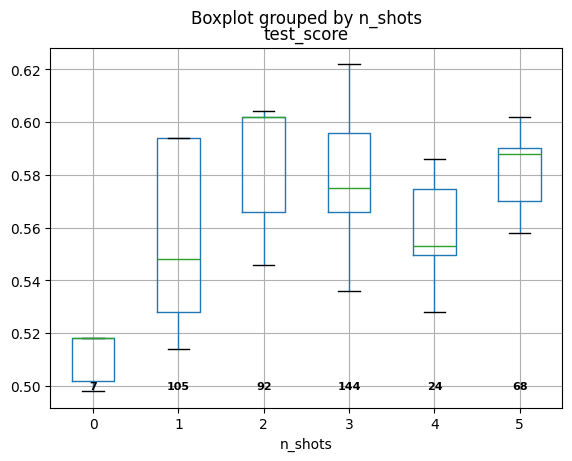

In [712]:
# correlation between number shots and score => boxplot, and give number of samples per n_shots
fig = df.boxplot(column="test_score", by="n_shots", showfliers=False)
# add number of samples per n_shots
num_samples = df.groupby("n_shots").size()
for i, n in enumerate(num_samples):
    fig.text(
        i + 1,
        0.5,
        n,
        ha="center",
        va="center",
        rotation=0,
        fontsize=8,
        color="black",
        fontweight="bold",
    )

plt.show();

In [713]:
# group df by step and get the mean of the values (ignore stings)
df_grouped = df.groupby("step", as_index=False).mean(numeric_only=True)
# df_grouped["cum_input_tokens"] = df_grouped["input_tokens_downstream_llm"].cumsum()

# join the maximum score for each step
df_grouped = df_grouped.join(
    df.groupby("step", as_index=False).max()[["step", "score"]].set_index("step"),
    on="step",
    rsuffix="_max",
)

df_grouped

,step,time_elapsed,score,input_tokens_meta_llm,output_tokens_meta_llm,input_tokens_downstream_llm,output_tokens_downstream_llm,test_score,total_tokens,output_tokens_downstream_llm_cum,output_tokens_meta_llm_cum,input_tokens_downstream_llm_cum,input_tokens_meta_llm_cum,n_shots,prompt_len,score_max
0,1,203.501687,0.523703,1437.0,453.0,369773.0,60868.0,0.5758,2378920.5,334774.0,2491.5,2033751.5,7903.5,3.5,954.0,0.563333
1,2,129.064003,0.513822,1522.0,554.0,332686.0,59435.0,0.5796,6493393.5,935572.5,7577.0,5527503.0,22741.0,3.4,1018.8,0.544444
2,3,141.979824,0.506453,1528.0,568.0,375427.0,69443.0,0.5752,10725593.0,1584966.5,13194.0,9089438.5,37994.0,3.2,1128.7,0.530658
3,4,86.078767,0.521832,1550.0,527.0,204656.0,34837.0,0.5756,14065575.0,2089063.5,18648.5,11904468.0,53395.0,3.1,1111.3,0.541135
4,5,100.396904,0.515601,1595.0,656.0,238862.0,47439.0,0.5724,16739676.0,2506744.5,24628.0,14139161.0,69142.5,3.2,1185.3,0.541135
5,6,69.237370,0.517379,1567.0,549.0,153295.0,27837.0,0.5704,19046024.0,2873323.5,30599.5,16057162.5,84938.5,3.1,1123.0,0.541135
6,7,76.510851,0.520299,1655.0,682.0,180861.0,35928.0,0.5730,21075833.0,3196194.0,36821.0,17741725.5,101092.5,3.2,1110.6,0.541135
7,8,111.541661,0.517394,1730.0,800.0,259624.0,60984.0,0.5742,23839159.0,3693282.0,44290.0,19983532.0,118055.0,3.1,1132.9,0.541135
8,9,28.814615,0.541354,1676.0,702.0,40885.0,13695.0,0.5704,25606549.0,4043032.5,51751.0,21376707.5,135058.0,3.0,1110.9,0.585057
9,10,121.259262,0.513915,1869.0,919.0,243359.0,79986.0,0.5652,27656591.5,4544583.0,59964.5,22899164.5,152879.5,2.6,1090.9,0.541135


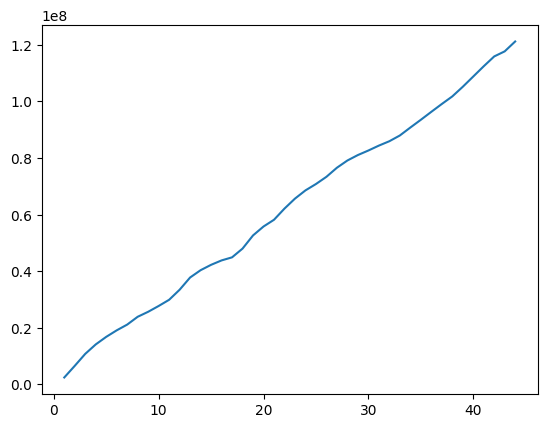

In [714]:
# plot step vs total tokens
plt.plot(df_grouped["step"], df_grouped["total_tokens"])

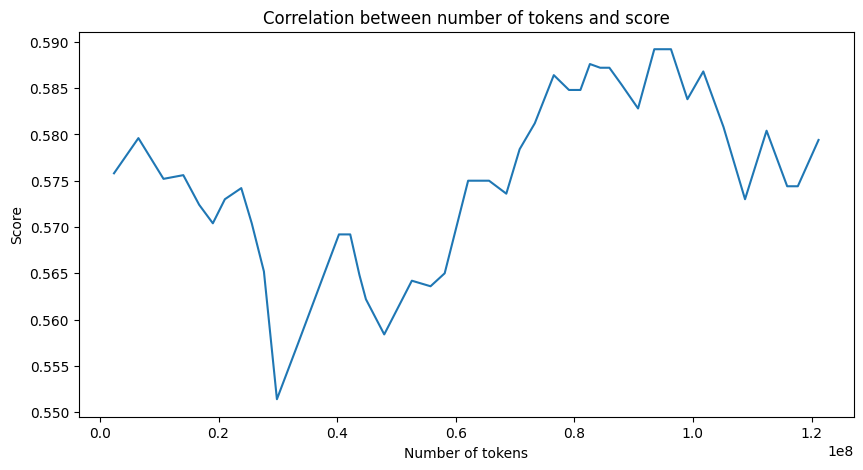

In [715]:
# plot score vs total tokens
plt.figure(figsize=(10, 5))
plt.title("Correlation between number of tokens and score")
plt.xlabel("Number of tokens")
plt.ylabel("Score")
plt.plot(df_grouped["total_tokens"], df_grouped["test_score"])
plt.show()

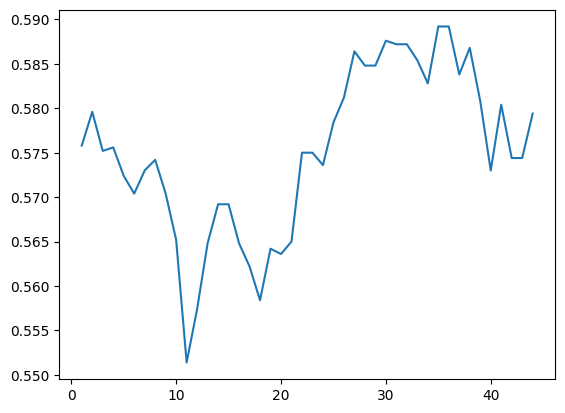

In [716]:
# plot token count vs step and adapt y-axis to min and max
column = "test_score"
plt.plot(df_grouped["step"], df_grouped[column])
plt.show();

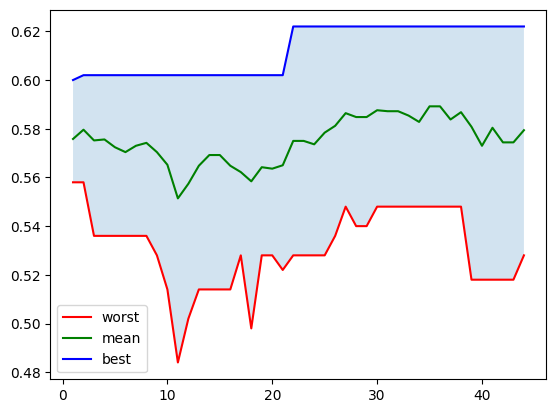

In [717]:
# x_axis => step, y_axis => worst_score, mean_score, best_score
col = "test_score"

worst_scores = df.groupby("step", as_index=False).min(numeric_only=True)[["step", col]]
mean_scores = df.groupby("step", as_index=False).mean(numeric_only=True)[["step", col]]
best_scores = df.groupby("step", as_index=False).max(numeric_only=True)[["step", col]]

plt.plot(worst_scores["step"], worst_scores[col], label="worst", color="red")
plt.plot(mean_scores["step"], mean_scores[col], label="mean", color="green")
plt.plot(best_scores["step"], best_scores[col], label="best", color="blue")
# fill area between lines
plt.fill_between(mean_scores["step"], worst_scores[col], best_scores[col], alpha=0.2)
plt.legend()
plt.show();

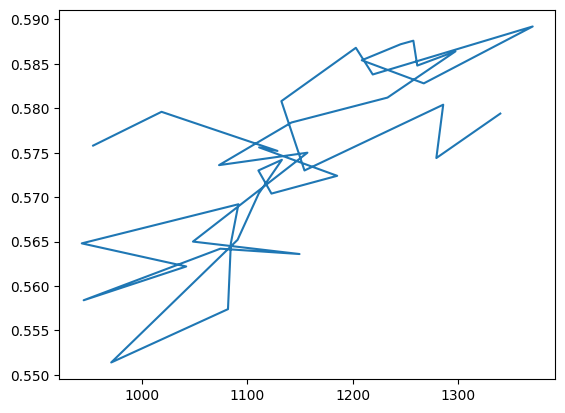

In [718]:
# plot score vs prompt length
plt.plot(df_grouped["prompt_len"], df_grouped["test_score"])
plt.show();

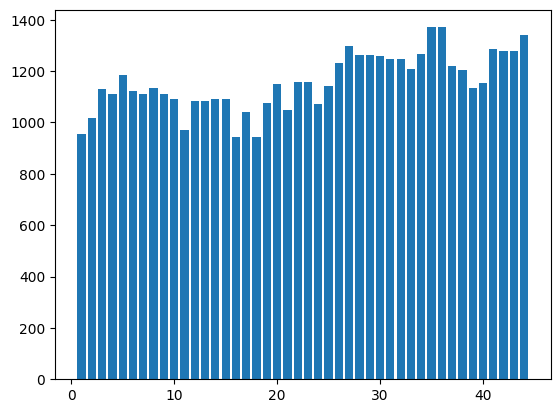

In [719]:
# prompt length vs step
plt.bar(df_grouped["step"], df_grouped["prompt_len"]);

### Analyze best prompts per step

In [720]:
df_best = df.groupby("step").apply(lambda x: x.nlargest(1, "score")).reset_index(drop=True)
# df_best

C:\Users\tzehl\AppData\Local\Temp\ipykernel_3992\373190983.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_best = df.groupby("step").apply(lambda x: x.nlargest(1, "score")).reset_index(drop=True)


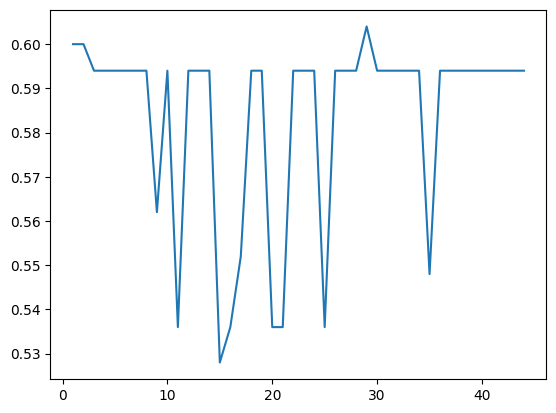

In [721]:
# max a line plot of the best score vs step
plt.plot(df_best["step"], df_best["test_score"]);

## Analyze Racing

In [722]:
from pprint import pprint as pp

p = lambda x: (pp(x.replace("\r", ""), compact=True, width=200))

In [723]:
df["test_score"].nlargest(10)

213    0.622
223    0.622
233    0.622
242    0.622
254    0.622
262    0.622
272    0.622
286    0.622
292    0.622
302    0.622
Name: test_score, dtype: float64

In [736]:
# best prompt
col = "test_score"
k_best = 30

best_prompt = df[df[col] == df[col].nlargest(k_best).values[k_best - 1]]
print("unique?", len(best_prompt["prompt"].unique()))
print("number of shots: ", best_prompt["n_shots"].values[0])
print("score: ", best_prompt[col].values[0])
print("first occurence: ", best_prompt["step"].values[0])
print("last occurence: ", best_prompt["step"].values[-1])
print("last train score: ", best_prompt["score"].values[-1].round(2))

p(best_prompt["prompt"].unique()[0])

unique? 1
number of shots:  2
score:  0.604
first occurence:  25
last occurence:  44
last train score:  0.52
('Movie sentiment classification task: Identify the emotional tone of the movie review and determine the sentiment. From the five sentiment categories - very negative, negative, neutral, positive, '
 'or very positive, determine the sentiment that best describes the overall sentiment of the movie review. Analyze the emotional tone of the given movie review and determine the sentiment expressed. '
 'Categorize it into one of the five sentiment levels: very negative, negative, neutral, positive, or very positive. Your classification should be enclosed between <final_answer> and </final_answer> '
 'markers. From the five sentiment categories - very negative, negative, neutral, positive, or very positive, assess the emotional tone of the provided movie review and determine the sentiment that '
 'best represents the overall sentiment of the movie review. Provide your answer in the fo

In [725]:
# load the prompt scores per block
path = path.replace("step_results_eval", "prompt_scores")

df_blocks = pd.read_csv(path)
# round all numbers to 2 decimal places
df_blocks = df_blocks.round(2)

df_blocks

,Unnamed: 0,3,5,7,6,8,0,9,4,1,2
0,Analyze the emotional tone of a movie review a...,NaN,NaN,0.40,NaN,0.43,0.43,NaN,NaN,NaN,NaN
1,Analyze the emotional tone of a movie review a...,NaN,NaN,NaN,NaN,NaN,NaN,0.37,NaN,NaN,NaN
2,Analyze the emotional tone of a movie review a...,0.57,0.57,0.40,0.57,0.47,0.43,0.43,0.60,0.57,0.70
3,Analyze the emotional tone of a movie review a...,NaN,NaN,NaN,0.40,NaN,NaN,0.57,NaN,0.43,NaN
4,Analyze the emotional tone of the given movie ...,0.47,0.47,0.53,0.43,NaN,0.63,0.47,0.60,0.47,NaN
...,...,...,...,...,...,...,...,...,...,...,...
174,Movie sentiment classification task: You are p...,0.63,0.43,0.70,0.50,0.57,0.30,0.67,0.50,0.63,0.53
175,Movie sentiment classification task: You are p...,0.53,0.47,0.43,0.53,0.43,0.77,0.40,0.50,0.50,0.57
176,Please analyze this movie review and place it ...,NaN,NaN,NaN,NaN,NaN,0.20,NaN,NaN,NaN,NaN
177,Read the movie review and identify its sentime...,NaN,NaN,0.30,0.60,0.73,0.63,NaN,0.47,0.63,NaN


In [726]:
# get number of blocks per prompt by counting non nans per columns
n_blocks = df_blocks.count(axis=1) - 1

In [727]:
n_blocks

0       3
1       1
2      10
3       3
4       8
       ..
174    10
175    10
176     1
177     6
178    10
Length: 179, dtype: int64

In [728]:
df_count = pd.DataFrame({"n_blocks": n_blocks.values, "prompt": df_blocks["Unnamed: 0"]})

In [729]:
df_count["n_blocks"].value_counts()

n_blocks
10    86
1     28
2     15
3     12
6      9
4      9
5      7
8      5
9      5
7      3
Name: count, dtype: int64

In [730]:
# join with df
df_count = df_count.join(df.set_index("prompt"), on="prompt", how="left", lsuffix="_rrr")

# bin by test_score
df_count["test_score_bin"] = pd.cut(df_count["test_score"], bins=5)

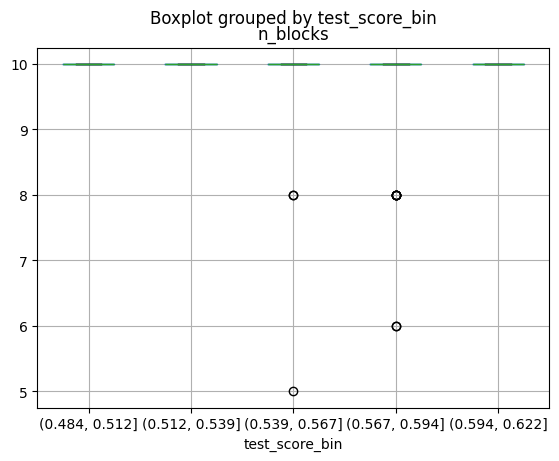

In [731]:
# evals vs score => boxplot
df_count.boxplot(column="n_blocks", by="test_score_bin");

<Axes: ylabel='count'>

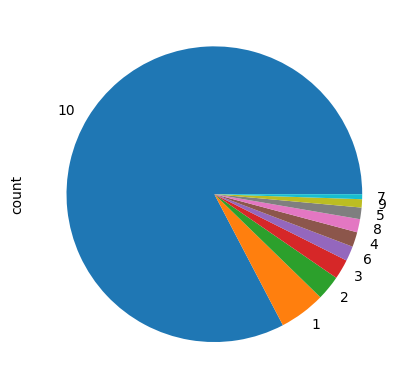

In [732]:
# pie chart of number of blocks per prompt
df_count["n_blocks"].value_counts().plot.pie()

In [733]:
df_count["n_blocks"].describe()

count    554.000000
mean       8.897112
std        2.638269
min        1.000000
25%       10.000000
50%       10.000000
75%       10.000000
max       10.000000
Name: n_blocks, dtype: float64